In [202]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import time
import logging
import warnings

warnings.filterwarnings("ignore")

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

logger = logging.getLogger(__name__)

symbol = 'BTCUSDT'
qty = 0.002

Get Past Data

In [203]:
def get_kline_data(pair, interval = "5m", limit = 1):
    try:
        # User inputs
        # Prepare the request body (JSON)
        params = {
            'pair': pair,
            'interval': interval,
            'limit': limit
        }

        # Headers for the POST request (no API key or signature required)
        headers = {
            'Content-Type': 'application/json'
        }

        
        kline_url = "https://api.pi42.com/v1/market/klines"

        for attempt in range(3):
            try:
                response = requests.post(kline_url, json=params, headers=headers)
                response.raise_for_status() # Raises an error for 4xx/5xx responses
                response_data = response.json()
                break  

            except requests.exceptions.RequestException:
                print(f"Retrying... ({attempt + 1})")
                time.sleep(10)  
        
        return response_data

    except ValueError:
        print("Please enter valid inputs for pair, interval.")
    except requests.exceptions.HTTPError as err:
        print(f"Error: {err.response.text if err.response else err}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")



def make_init_data(contract_pair, time = "1m", limit = 100):
    
    try:
        logger.info(f"Fetching kline data for contract pair: {contract_pair}")
        info = get_kline_data(contract_pair, interval=time, limit=limit)
        
        data = []

        for i in info:
            high = float(i['high'])
            low = float(i['low'])
            close = float(i['close'])
            
            timestamp = pd.to_datetime(int(i['startTime']), unit='ms')
            
            data.append({'Timestamp': timestamp, 'High': high, 'Low': low, 'Close': close})
        
        # Create the DataFrame
        df = pd.DataFrame(data)
        df.set_index('Timestamp')
        df.index = pd.to_datetime(df.index)
        
        logger.info("DataFrame created successfully.")
        return df
    
    except Exception as e:
        logger.error(f"Error while making initial data: {e}")
        raise

In [216]:
df = make_init_data(symbol.upper(), time = "5m", limit = 10000)

[*********************100%***********************]  1 of 1 completed


In [217]:
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-12-31 00:00:00+00:00,92619.421875,92645.835938,92554.828125,92554.828125,92554.828125,0
2024-12-31 00:05:00+00:00,92589.546875,92693.507812,92589.546875,92635.828125,92635.828125,0
2024-12-31 00:10:00+00:00,92683.171875,92683.171875,92572.648438,92629.835938,92629.835938,0
2024-12-31 00:15:00+00:00,92648.312500,92648.312500,92510.296875,92510.296875,92510.296875,0
2024-12-31 00:20:00+00:00,92522.265625,92532.156250,92416.562500,92416.562500,92416.562500,0
...,...,...,...,...,...,...
2025-01-05 23:35:00+00:00,98400.101562,98436.273438,98400.101562,98436.273438,98436.273438,10119168
2025-01-05 23:40:00+00:00,98448.906250,98465.585938,98432.984375,98432.984375,98432.984375,20510720
2025-01-05 23:45:00+00:00,98412.906250,98412.906250,98364.179688,98395.812500,98395.812500,22151168


In [ ]:
df

In [218]:
len(df)

1706

In [219]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt, atr

In [220]:
df['st'], df['st_upt'], df['st_dt'], df['atr'] = get_supertrend(df['High'], df['Low'], df['Close'], 10, 3)

In [221]:
len(df)

1706

BUY SIGNAL

In [222]:
length = len(df['st_upt'])
close = list(df['Close'])
st_upt = list(df['st_upt'])
status = 0
capital_real = 40
lev = 25

capital = capital_real * 25

equity_curve = [capital_real]

for i in range(1, length):
    #print(i)
    curr = st_upt[i]
    prev = st_upt[i - 1]

    if pd.isna(prev) and curr > 0 and status == 0:
        logger.info("BUY SIGNAL detected.")
        entry_price = close[i]
        logger.info(f"Buy Price: {entry_price}")
        status = 1
    
    if pd.isna(curr) and prev > 0 and status == 1:
        logger.info("SELL SIGNAL detected.")
        exit_price = close[i]
        logger.info(f"Sell Price: {exit_price}")
        status = 0
        
        qty = capital / entry_price
        logger.info(f"Qty: {qty}")
        diff = capital_real + (exit_price - entry_price) * qty
        logger.info(f"Diff: {diff}")

        equity_curve.append(diff)
        

2025-01-09 20:30:44,569 - INFO - BUY SIGNAL detected.
2025-01-09 20:30:44,570 - INFO - Buy Price: 92389.921875
2025-01-09 20:30:44,572 - INFO - SELL SIGNAL detected.
2025-01-09 20:30:44,572 - INFO - Sell Price: 92291.8046875
2025-01-09 20:30:44,573 - INFO - Qty: 0.27059228423013537
2025-01-09 20:30:44,574 - INFO - Diff: 973.4502461121385
2025-01-09 20:30:44,577 - INFO - BUY SIGNAL detected.
2025-01-09 20:30:44,578 - INFO - Buy Price: 92537.125
2025-01-09 20:30:44,580 - INFO - SELL SIGNAL detected.
2025-01-09 20:30:44,582 - INFO - Sell Price: 93764.3515625
2025-01-09 20:30:44,583 - INFO - Qty: 0.2701618404505219
2025-01-09 20:30:44,584 - INFO - Diff: 1331.5497867747674
2025-01-09 20:30:44,585 - INFO - BUY SIGNAL detected.
2025-01-09 20:30:44,586 - INFO - Buy Price: 93994.1953125
2025-01-09 20:30:44,587 - INFO - SELL SIGNAL detected.
2025-01-09 20:30:44,590 - INFO - Sell Price: 94929.265625
2025-01-09 20:30:44,591 - INFO - Qty: 0.2659738712255918
2025-01-09 20:30:44,592 - INFO - Diff: 12

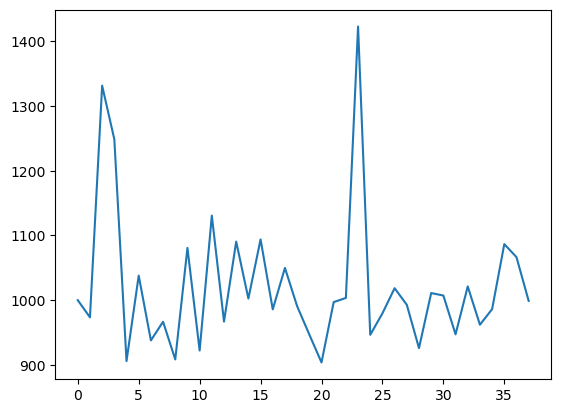

In [223]:
import matplotlib.pyplot as plt
plt.plot(equity_curve)

In [224]:
length = len(df['st_upt'])
close = list(df['Close'])
st_upt = list(df['st_upt'])
status = 0
capital_real = 1000
lev = 25

capital = capital_real * 25

equity_curve = [capital_real]

for i in range(1, length):
    #print(i)
    curr = st_upt[i]
    prev = st_upt[i - 1]

    if pd.isna(prev) and curr > 0 and status == 1:
        logger.info("BUY SIGNAL detected.")
        entry_price = close[i]
        logger.info(f"Buy Price: {entry_price}")
        status = 0

        qty = capital / exit_price
        logger.info(f"Qty: {qty}")
        diff = capital_real + (exit_price - entry_price) * qty
        logger.info(f"Diff: {diff}")

        equity_curve.append(diff)
    
    if pd.isna(curr) and prev > 0 and status == 0:
        logger.info("SELL SIGNAL detected.")
        exit_price = close[i]
        logger.info(f"Sell Price: {exit_price}")
        status = 1

2025-01-09 20:30:45,316 - INFO - SELL SIGNAL detected.
2025-01-09 20:30:45,317 - INFO - Sell Price: 92291.8046875
2025-01-09 20:30:45,319 - INFO - BUY SIGNAL detected.
2025-01-09 20:30:45,321 - INFO - Buy Price: 92537.125
2025-01-09 20:30:45,323 - INFO - Qty: 0.27087995607681514
2025-01-09 20:30:45,326 - INFO - Diff: 933.5476445252494
2025-01-09 20:30:45,327 - INFO - SELL SIGNAL detected.
2025-01-09 20:30:45,329 - INFO - Sell Price: 93764.3515625
2025-01-09 20:30:45,330 - INFO - BUY SIGNAL detected.
2025-01-09 20:30:45,331 - INFO - Buy Price: 93994.1953125
2025-01-09 20:30:45,333 - INFO - Qty: 0.2666258506926898
2025-01-09 20:30:45,335 - INFO - Diff: 938.717714629852
2025-01-09 20:30:45,337 - INFO - SELL SIGNAL detected.
2025-01-09 20:30:45,341 - INFO - Sell Price: 94929.265625
2025-01-09 20:30:45,342 - INFO - BUY SIGNAL detected.
2025-01-09 20:30:45,344 - INFO - Buy Price: 93720.796875
2025-01-09 20:30:45,345 - INFO - Qty: 0.26335398083408484
2025-01-09 20:30:45,347 - INFO - Diff: 131

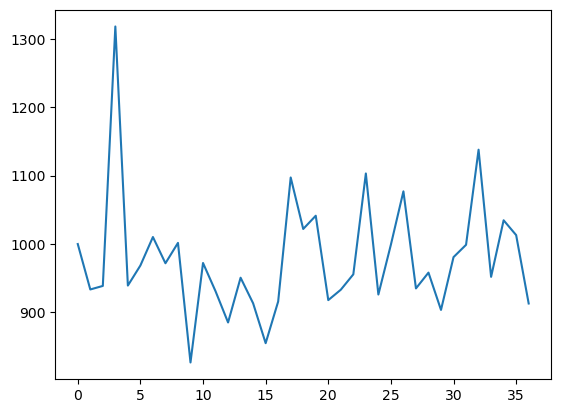

In [225]:
plt.plot(equity_curve)